In [2]:
import numpy as np
from math import*
#import matplotlib.pyplot 
import matplotlib.pyplot as plt
import random
import scipy
import scipy.stats
#from scipy.optimize import NonlinearConstraint
plt.rcParams["figure.figsize"] = (8,8)

Permières explorations concernant le projet 

Rappel du projet:
Exploration du problème de bandit stochastique dans la situation avec des bras de distributions avec espérance non-définie.

Premier cas (Bras de distribution de Cauchy)

Rappel

Fonction de densité de la loi de Cauchy:

$$f(x;x_0;a)=\frac{1}{\pi\,a\left[1+\left(\frac{x-x_0}{a}\right)^2\right]}=\frac{1}{\pi}\left[\frac{a}{(x-x_0)^2+a^2}\right]$$

$x_0\in\mathbb{R}$ est un paramètre de localisation et $a>0$ est un paramètre d'échelle.

L'espérance de la loi de Cauchy n'existe pas.

Voici quelques graphiques de la fonction de densité de la loi de Cauchy

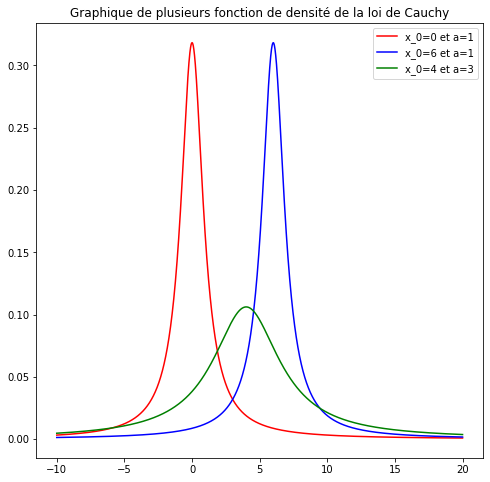

In [3]:
x=np.arange(-10,20,0.01)

loc1=0; a1=1;
loc2=6; a2=1;
loc3=4; a3=3;

y1=scipy.stats.cauchy.pdf(x, loc=0, scale=1)
y2=scipy.stats.cauchy.pdf(x, loc=6, scale=1)
y3=scipy.stats.cauchy.pdf(x, loc=4, scale=3)

plt.plot(x,y1,color='red', label='x_0={} et a={}'.format(loc1,a1))
plt.plot(x,y2,color='blue', label='x_0={} et a={}'.format(loc2,a2))
plt.plot(x,y3,color='green', label='x_0={} et a={}'.format(loc3,a3))

plt.title('Graphique de plusieurs fonction de densité de la loi de Cauchy')
plt.legend()

L'expérimentation ci-dessous montre que tenté d'estimer le paramètre de localisation à l'aide de la moyenne empirique basée sur un échantillonnage ne produit pas de bon résultat, alors que celui basé sur la médiane l'est (robustesse).

In [9]:
def location_estimator(X):
    N = len(X)
    estimation = 0
    X_sorted = np.sort(X)

    for i in range(N):
        u = i / N+1
        estimation += (np.sin(4* np.pi * (u - 0.5)) / tan(np.pi * u - 0.5)) * X_sorted[i]
    
    return estimation / N

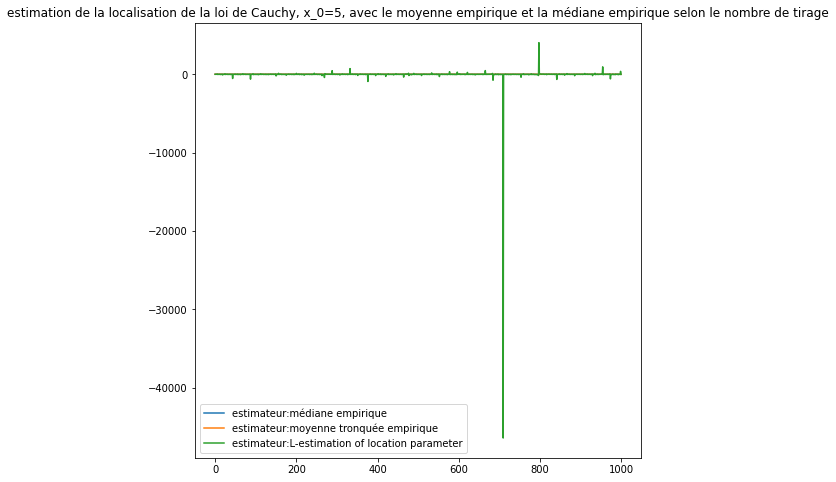

In [10]:
T=1000
T_MEAN = 0.25

X=[]
moyenne_empirique=np.zeros(T,dtype=np.float32)
mediane_empirique=np.zeros(T,dtype=np.float32)
tmean_empirique = np.zeros(T,dtype=np.float32)
l_estimation_empirique = np.zeros(T,dtype=np.float32)

for i in range(T):
    X.append(scipy.stats.cauchy.rvs(loc=5,scale=1,size=1))
    moyenne_empirique[i]=np.mean(X)
    mediane_empirique[i]=np.median(X)
    tmean_empirique[i] = scipy.stats.trim_mean(X, T_MEAN)
    l_estimation_empirique[i] = location_estimator(X)

# plt.plot(range(T),moyenne_empirique,label='estimateur:moyenne empirique')
plt.plot(range(T),mediane_empirique,label='estimateur:médiane empirique')
plt.plot(range(T),tmean_empirique,label='estimateur:moyenne tronquée empirique')
# plt.plot(range(T),l_estimation_empirique,label='estimateur:L-estimation of location parameter')

plt.title('estimation de la localisation de la loi de Cauchy, x_0=5, avec le moyenne empirique et la médiane empirique selon le nombre de tirage')
plt.legend()

Dans le cas simple de bras à distributions de Cauchy, il semble approprié que la mesure de performance (regret) pourrait simplement être défini en fonction du paramètre de localisation de la loi au lieu de la moyenne (qui n'existe pas). La classe suivante définit un bandit à distributions de Cauchy avec cette convention pour cumuler le regret.

In [5]:
class CauchyBandit :
    def __init__(self, loc, scale, seed = None):
        ''' Entrées:
                    - loc: un array décrivant les paramètres de localisations des lois de Cauchy décrivant les actions
                    - scale: un array décrivant les paramètres d'échelle des lois de Cauchy décrivant les actions
                    - seed (optionnel): un seed. '''

        np.random.seed(seed=seed)
        
        self.loc = loc
        
        self.scale= scale
        
        self.ps_regrets = []

        self.locstar = max(self.loc)
        
        self.kstar = np.argmax(loc)
        
        self.gaps = self.locstar - loc

        
    def get_K(self):
        ''' Return the number of actions . '''

        K = len(self.loc)
        
        return K
        
    def play(self,action):
        ''' Accept a parameter 0 <= k < K, logs the instant pseudo - regret ,
        and return the realization of a Bernoulli random variable with P(X =1)
        being the mean of the given action . '''

        ps_regrets_inst = self.loc - self.loc[action]

        #méthode de conténation append
        self.ps_regrets.append(self.gaps[action])
        
        reward = scipy.stats.cauchy.rvs(self.loc[action], self.scale[action],size=1)
        
        return reward

    def get_cumulative_regret(self):
        ''' Return an array of the cumulative sum of pseudo - regret per round . '''
        return np.cumsum(self.ps_regrets)

In [6]:
##Petit test pour montrer que la classe semble fonctionner.
bandittest=CauchyBandit(loc=np.array([2,6]),scale=np.array([1,1]),seed=1)
r=np.zeros(20)
for i in range(20):
    if i%2==0:
        r[i]=bandittest.play(0)
    else:
        r[i]=bandittest.play(1)
        
print(r)

print(bandittest.gaps)
    

[ 1.73324693e+00  6.82899050e+00 -2.78104158e+03  5.28459455e+00
 -1.30699056e-02  2.65004056e+00  4.90701340e-01  5.47278057e+00
  1.66381535e+00  6.12255447e+00  1.74054455e+00  6.65786480e+00
  6.63340744e-01  8.48271098e+00 -9.59371741e+00  6.59338249e+00
  1.73419835e+00  6.18649772e+00 -1.18420076e-01  4.60621161e+00]
[4 0]


On définit ci-dessous l'algorithme etc avec un nouveau boléen (median) qui indique si on utilise la moyenne empirique pour choisir l'action à jouer ou bien la médiane empirique.

In [7]:
def etc(bandit , T, m, discret=False, median=False):
    '''T: L'horizon
       m: Le nombre de tirage de chacune des actions dans le tour exploratoire
       discret: Pour faire un bris d'égalité ou non (nécessaire dans le cas de distributions discrètes)
       median: si True, mesure la médiane au lieu de la moyenne pour choisir l'action optimale '''
     
    K = bandit.get_K()  #Obtention du nombre d'actions possibles.
    
    # Phase d'exploration (m tours sur chaque action)
    
    R = []
   
    for k in range(K):
        R.append([])
    
    estimateurs = [] 
    
    for k in range(K):
        for j in range(m):
            R[k].append(bandit.play(k))             
        
        if median:
            estimateurs.append(np.median(R[k])) 
        else:
            estimateurs.append(np.mean(R[k]))
     
    # Calcul de l'action optimale

    ##Si la loi des bras est discrète, on doit gérer le cas où il peut y avoir bris d'égalité. 
    if(discret):
        kstar_est = np.where(estimateurs == max(estimateurs))[0]

        if (len(kstar_est) > 1):
            kstar_est = np.random.choice(kstar_est,1)[0]
    else:
        kstar_est = np.argmax(estimateurs)
            
    # Phase d'exploitation

    for t in range(m*K,T):
        r_t=bandit.play(kstar_est)

    return kstar_est


On compare maintenant la méthode etc(median=True) avec la méthode etc(median=True) dans une situation avec un bandit à deux bras de Cauchy de positions 5 et 6. 

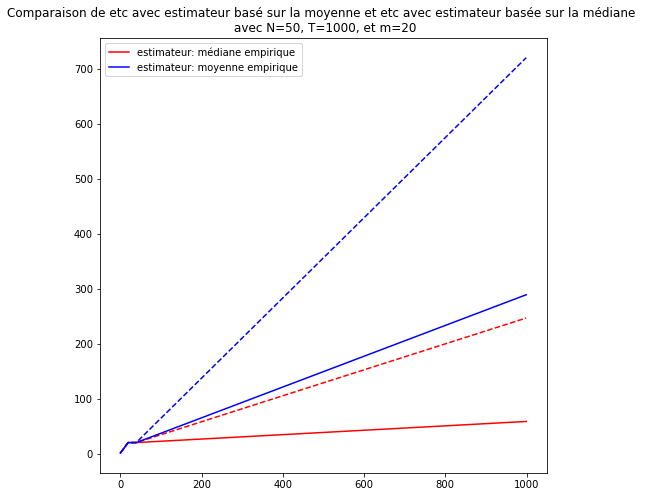

In [8]:
N,T = 50, 1000

m=20

loc=np.array([5,6])
scale=np.array([1,1])

cum_regrets_etc_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=None)
    etc(banditest, T=T, m=m, discret=False, median=True)
    cum_regrets_etc_median.append(banditest.get_cumulative_regret())

cum_regrets_etc_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_median)
cum_regrets_etc_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_median)

plt.plot(range(T),cum_regrets_etc_median_moy,color='red',label='estimateur: médiane empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_etc_median_moy + cum_regrets_etc_median_sd,color='red', linestyle='dashed')

cum_regrets_etc_moyenne = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=None)
    etc(banditest, T=T, m=m, discret=False, median=False)
    cum_regrets_etc_moyenne.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_moyenne)
cum_regrets_etc_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_moyenne)

plt.plot(range(T),cum_regrets_etc_moyenne_moy, color='blue', label='estimateur: moyenne empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_etc_moyenne_moy + cum_regrets_etc_moyenne_sd, color='blue', linestyle='dashed')

plt.title('Comparaison de etc avec estimateur basé sur la moyenne et etc avec estimateur basée sur la médiane \n avec N={}, T={}, et m={}'.format(N,T,m))
plt.legend()

#print(cum_regrets)
#print(cum_regrets_moy)
#print(cum_regrets_sd)


L'expérience montre que la méthode classique se fait déjouer par les queues lourdes de la distribution de Cauchy, alors que la méthode utilisant un estimateur de localisation plus robuste (ici la médiane) a de meilleurs performances.

On mène ci-dessous une étude plus complète avec des paramètres de localisations choisient aléatoirement dans l'intervalle (0,1).

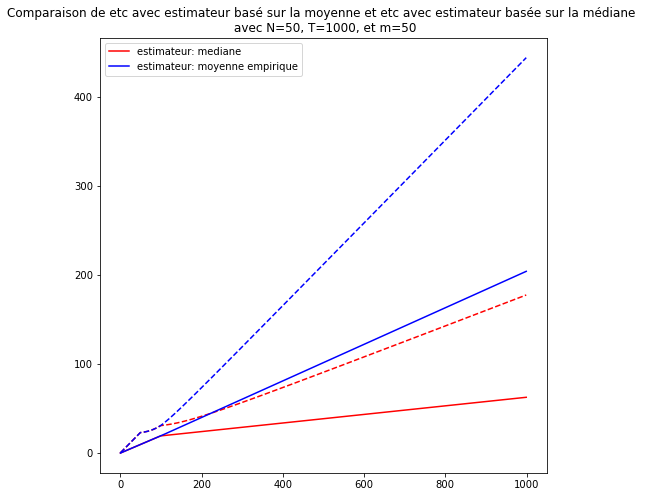

In [9]:
N,T = 50, 1000

m=50

loc=np.random.rand(50,2)

scale=np.array([1,1])

cum_regrets_etc_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=None)
    etc(banditest, T=T, m=m, discret=False, median=True)
    cum_regrets_etc_median.append(banditest.get_cumulative_regret())

cum_regrets_etc_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_median)
cum_regrets_etc_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_median)

plt.plot(range(T),cum_regrets_etc_median_moy,color='red',label='estimateur: mediane') #affichage du graphique
plt.plot(range(T),cum_regrets_etc_median_moy + cum_regrets_etc_median_sd,color='red', linestyle='dashed')

cum_regrets_etc_moyenne = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=None)
    etc(banditest, T=T, m=m, discret=False, median=False)
    cum_regrets_etc_moyenne.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_moyenne)
cum_regrets_etc_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_moyenne)

plt.plot(range(T),cum_regrets_etc_moyenne_moy, color='blue',label='estimateur: moyenne empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_etc_moyenne_moy + cum_regrets_etc_moyenne_sd, color='blue', linestyle='dashed')

plt.title('Comparaison de etc avec estimateur basé sur la moyenne et etc avec estimateur basée sur la médiane \n avec N={}, T={}, et m={}'.format(N,T,m))
plt.legend()

#print(cum_regrets)
#print(cum_regrets_moy)
#print(cum_regrets_sd)


Ci-dessous, on fait une étude plus exhaustive en faisant varier m

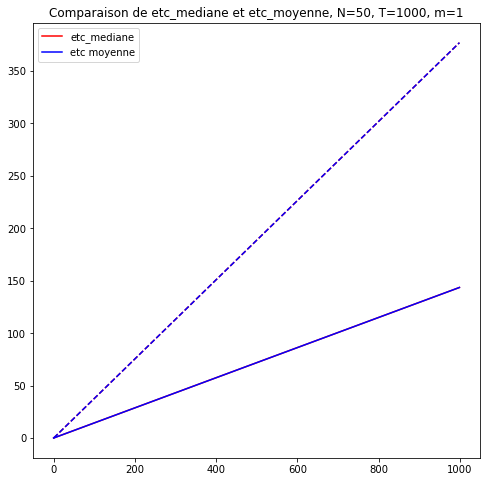

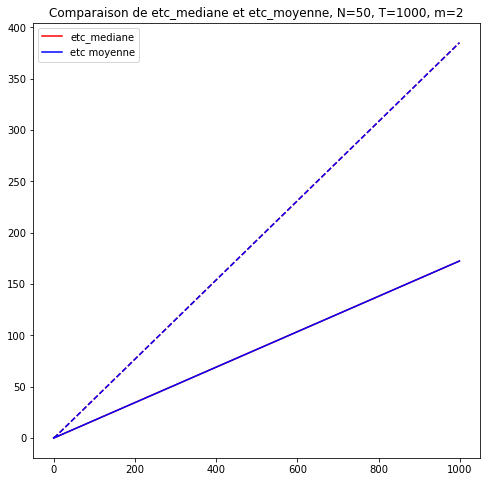

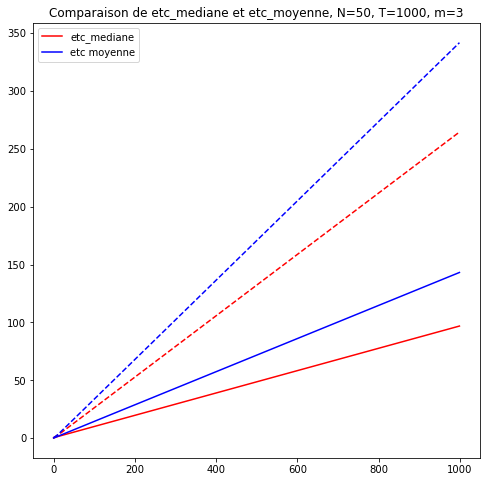

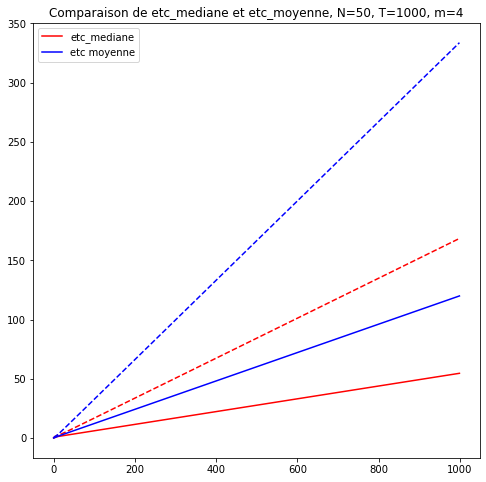

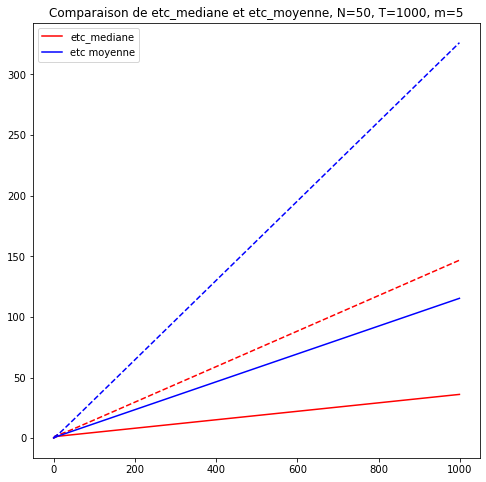

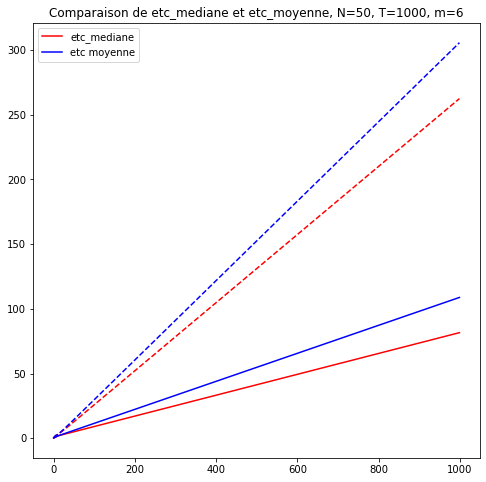

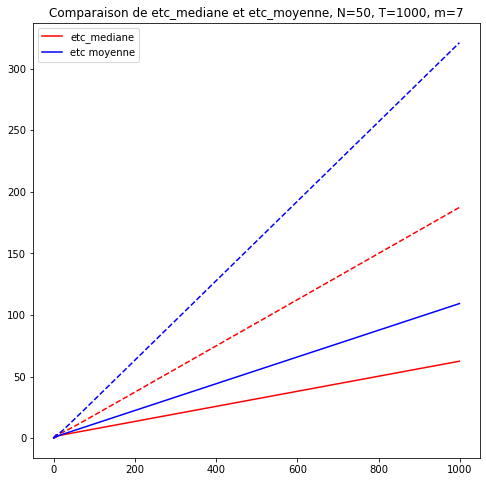

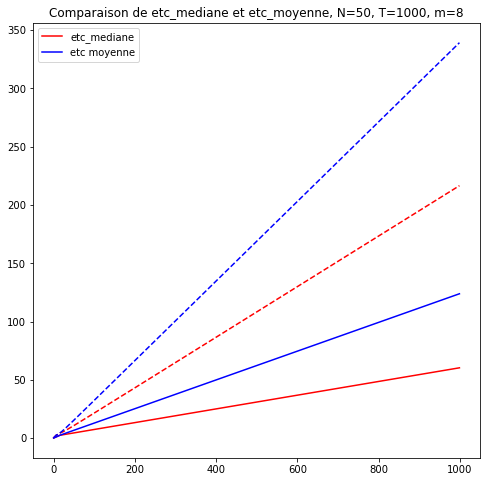

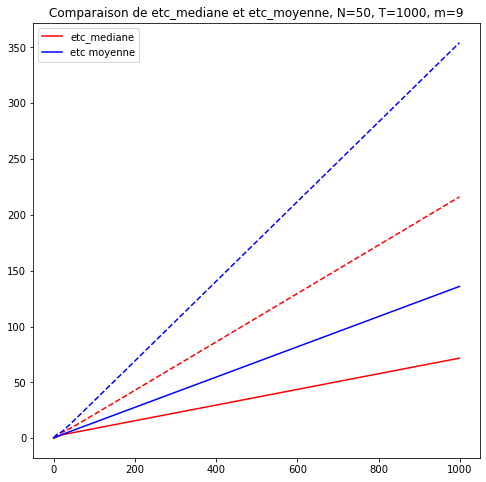

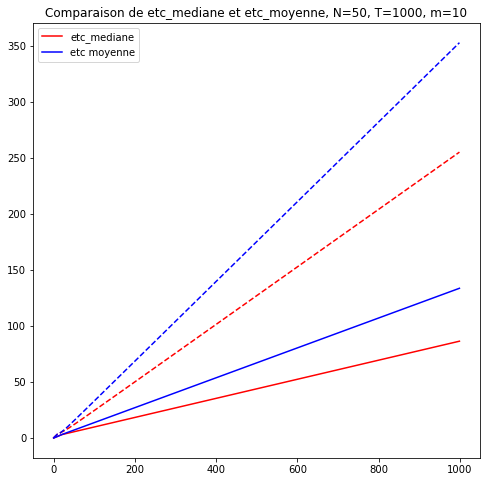

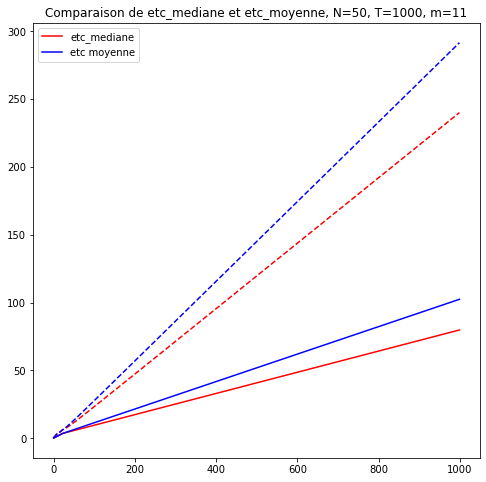

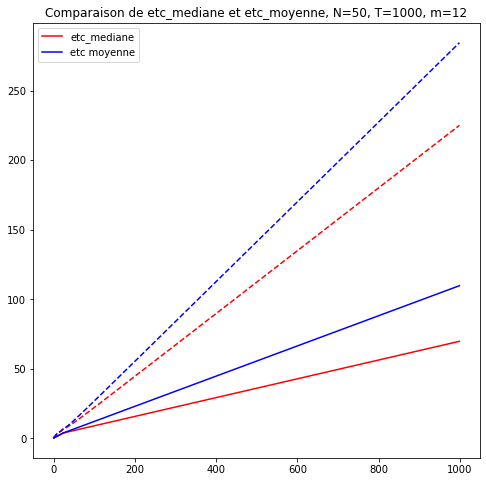

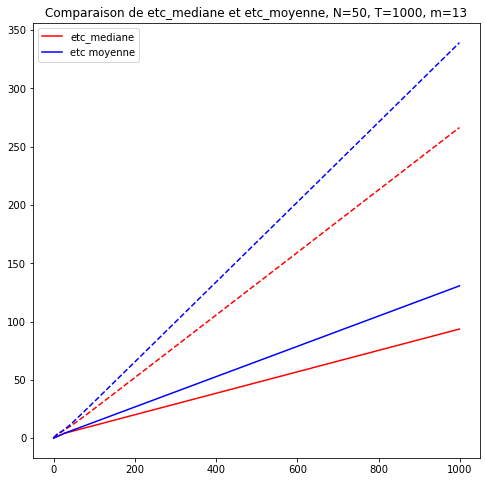

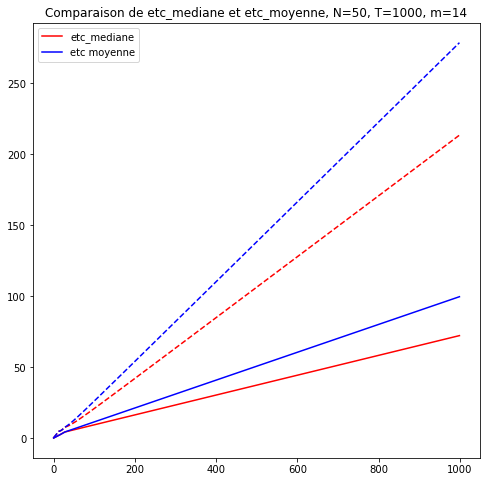

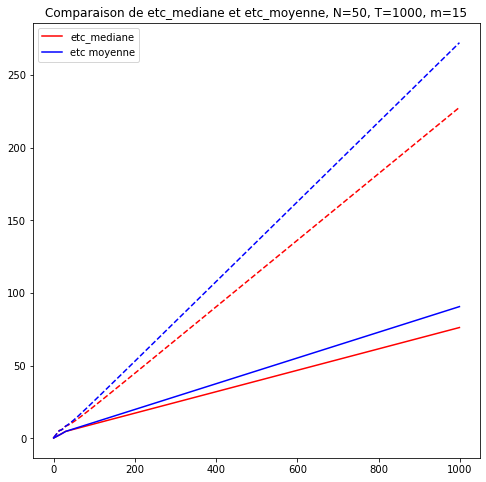

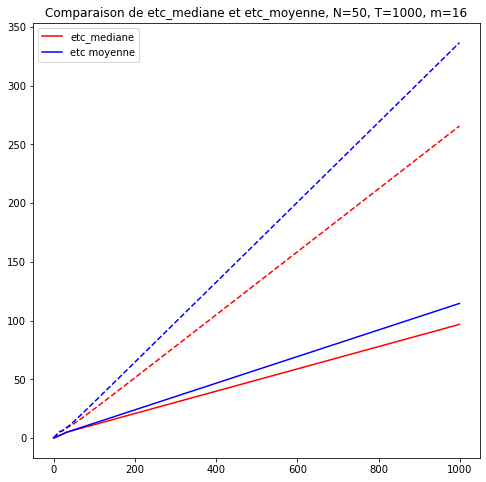

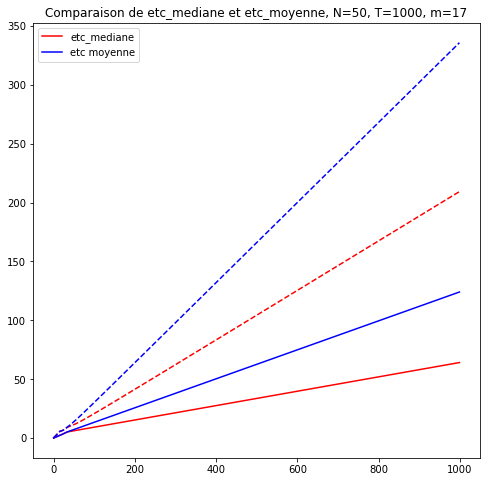

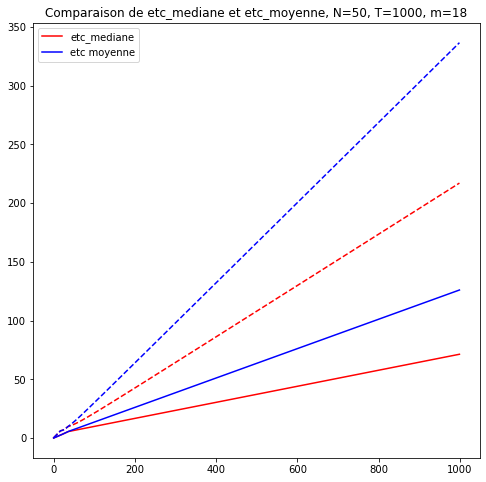

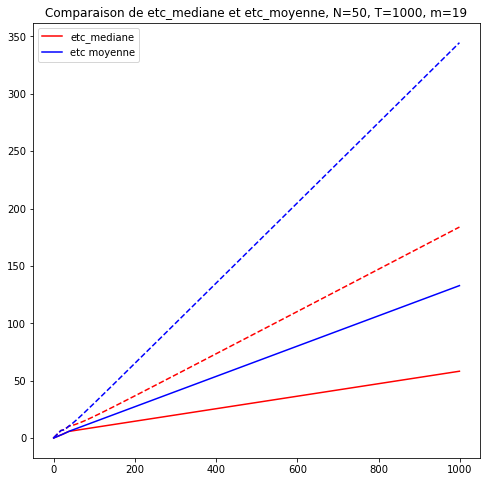

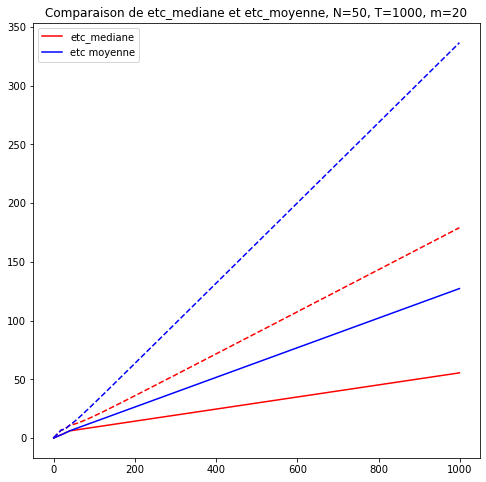

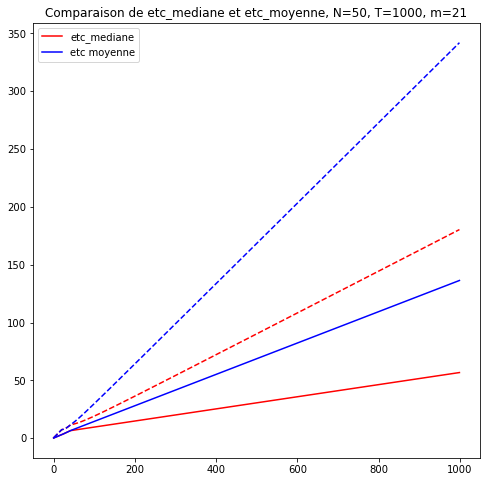

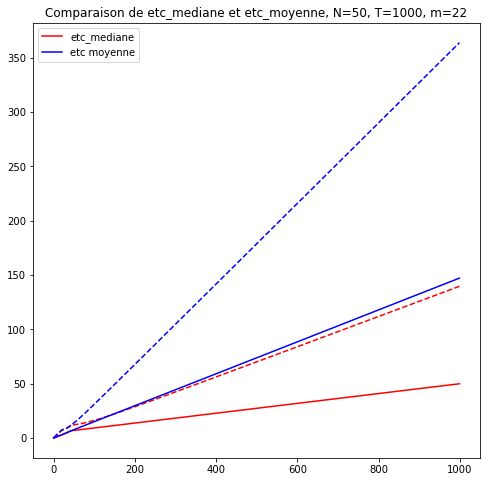

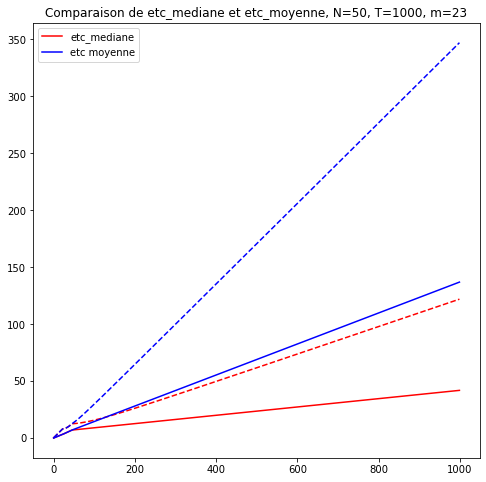

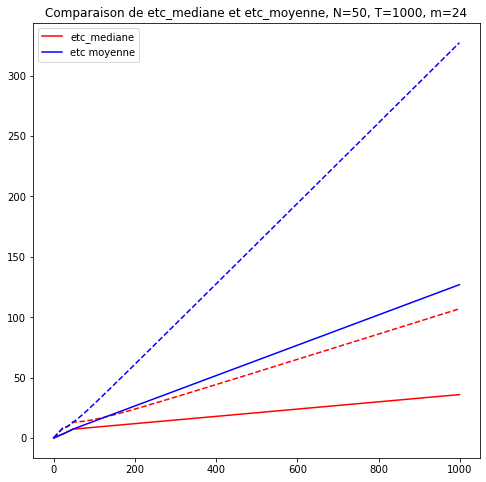

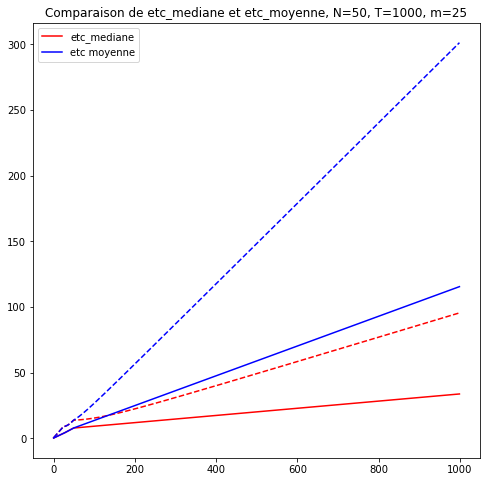

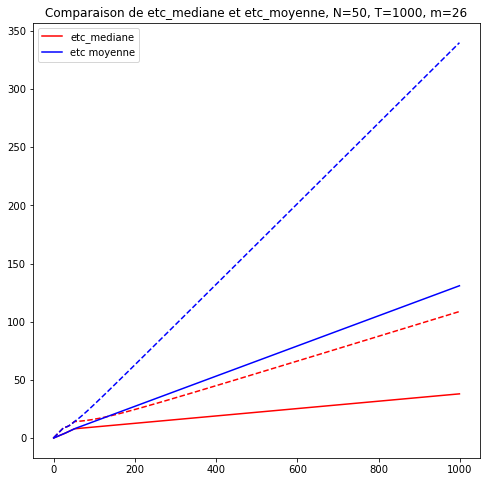

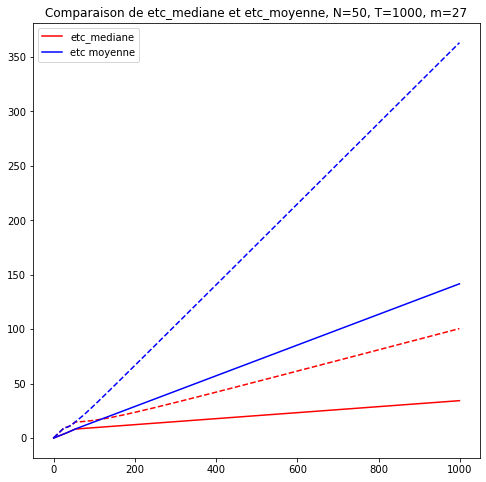

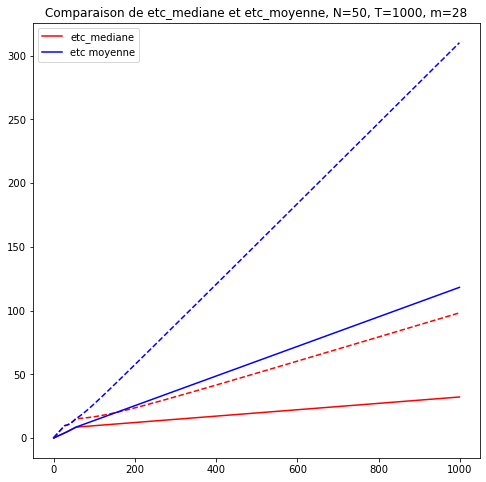

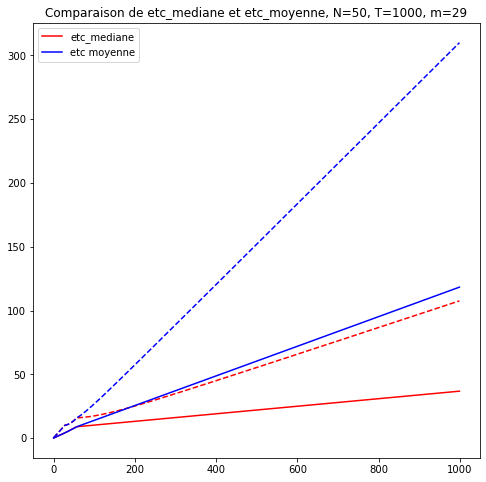

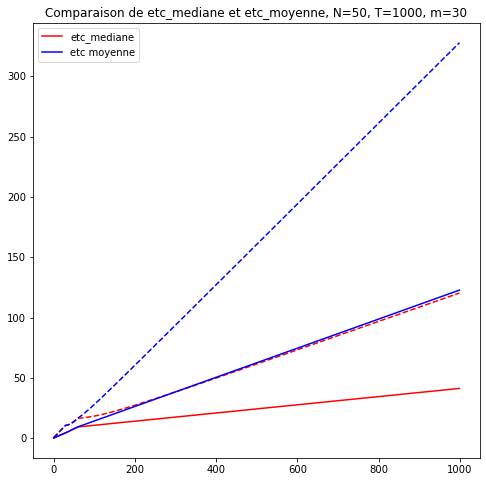

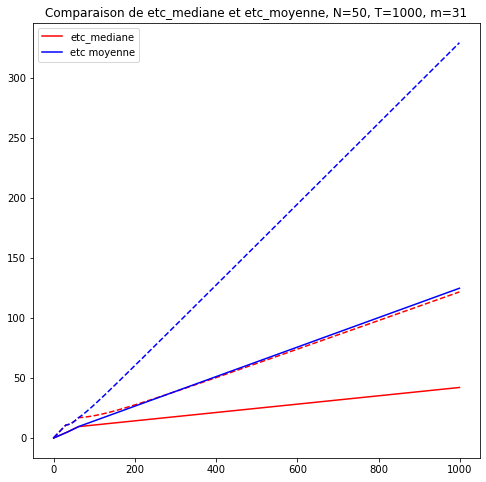

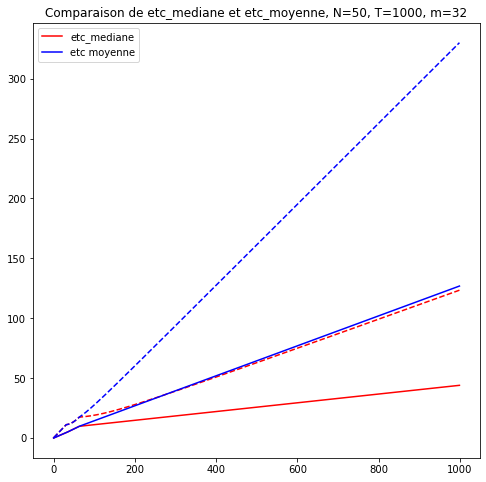

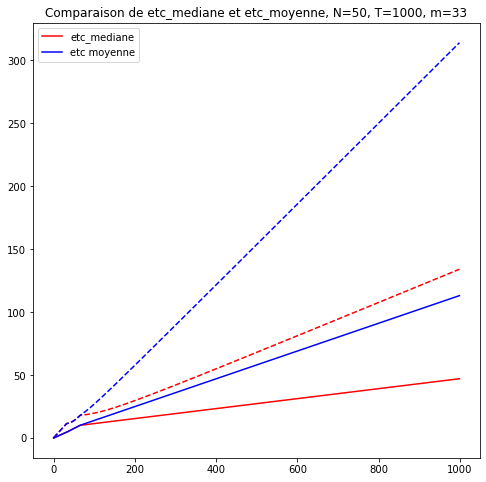

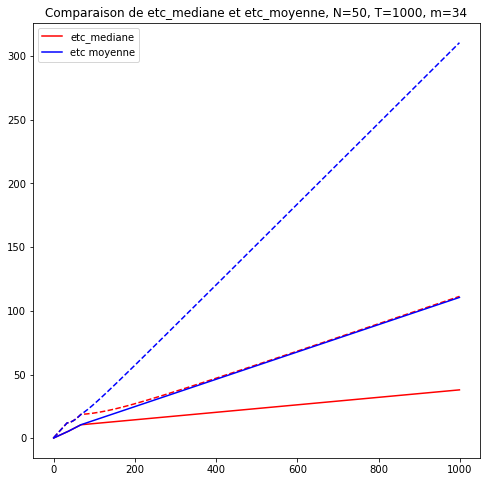

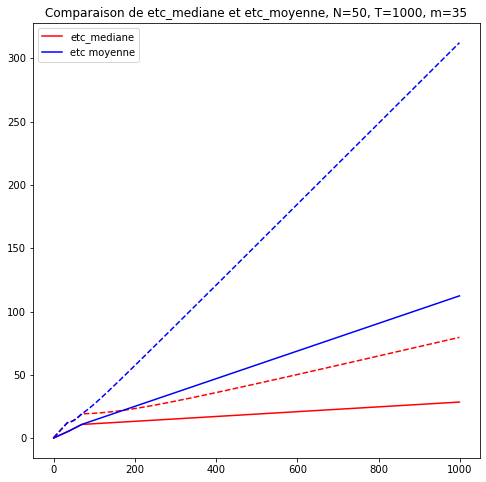

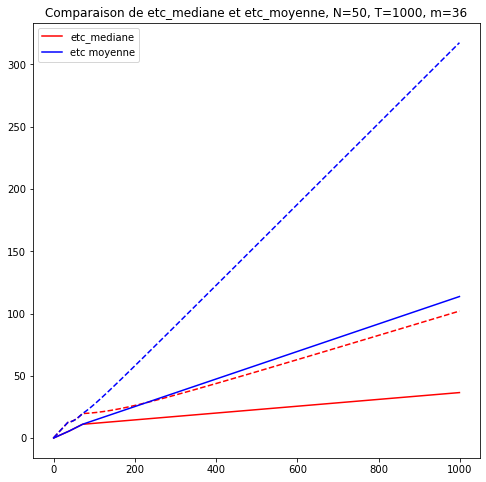

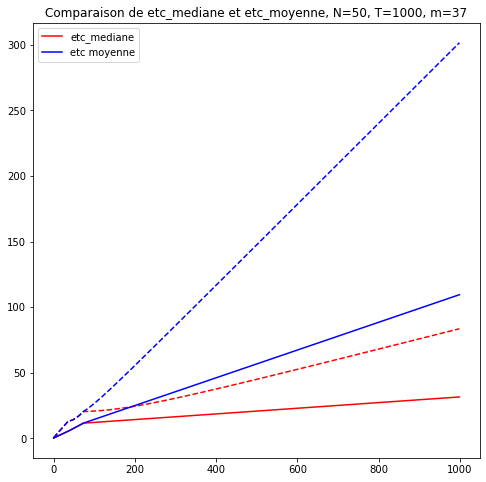

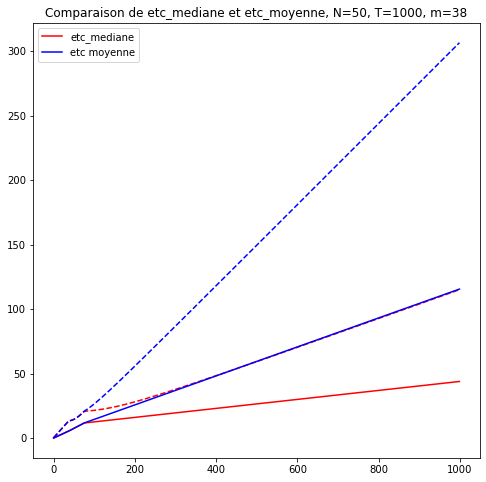

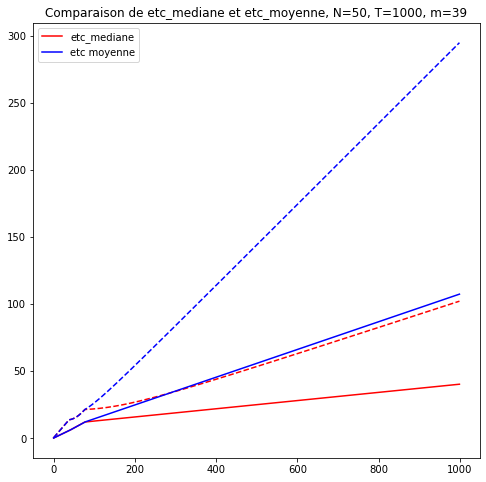

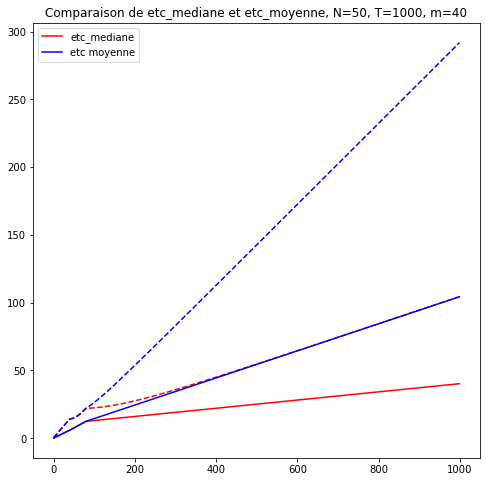

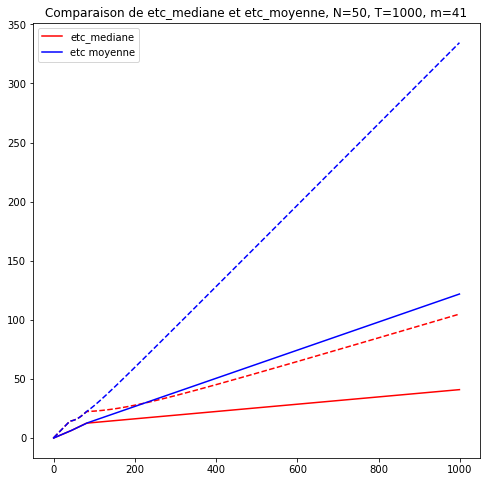

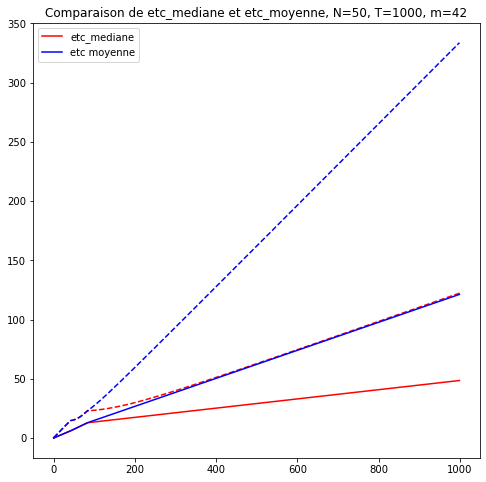

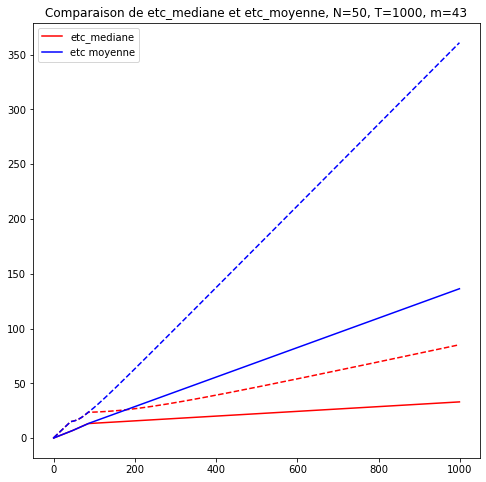

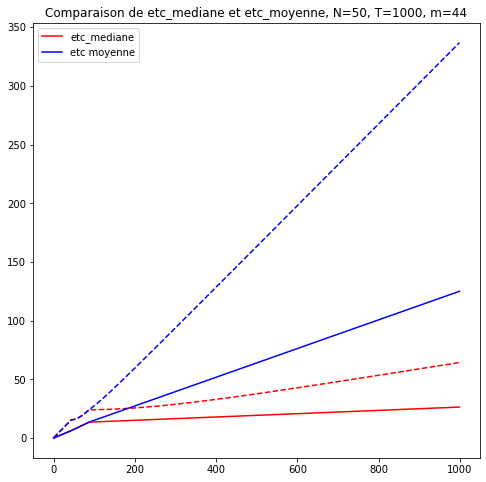

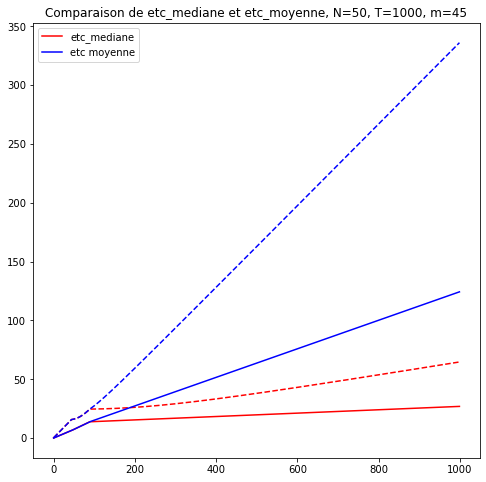

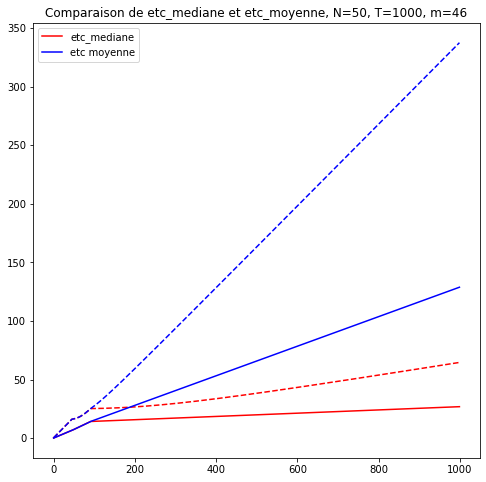

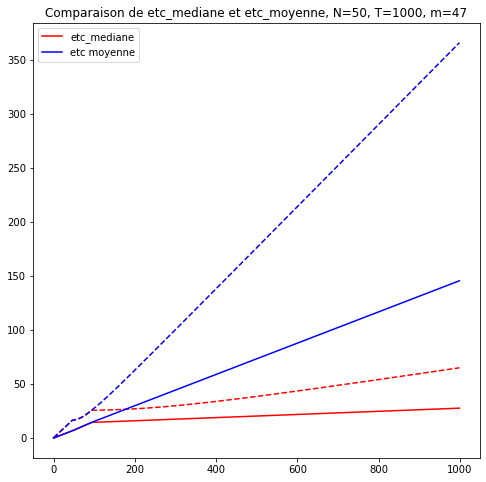

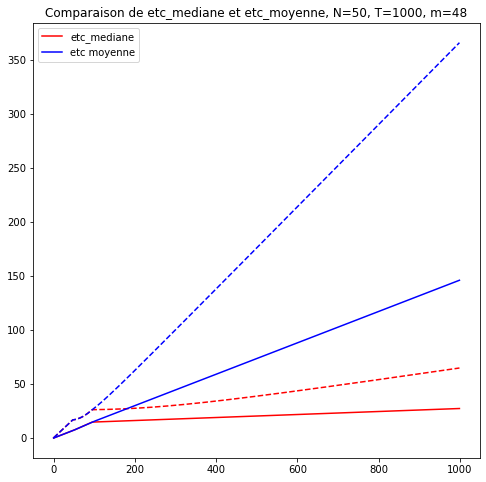

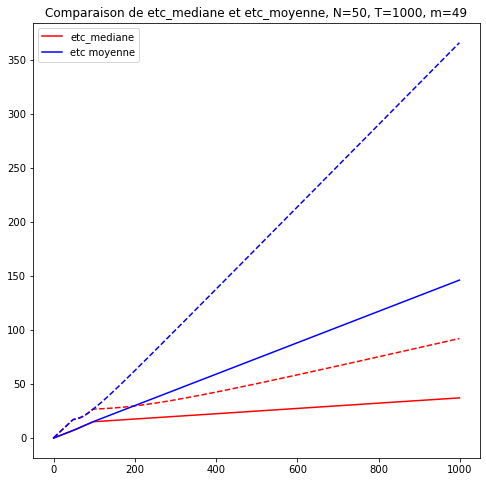

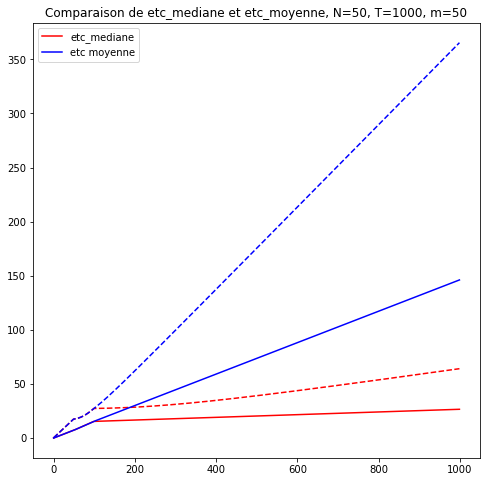

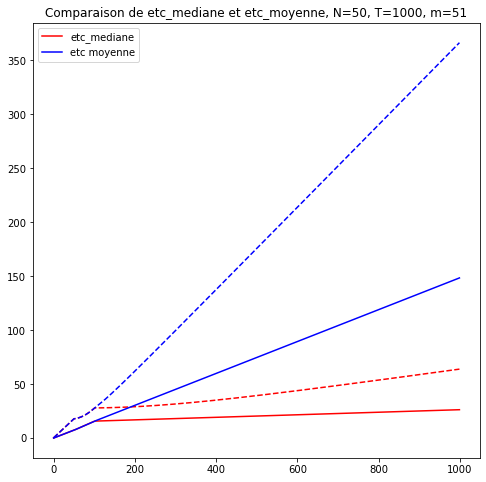

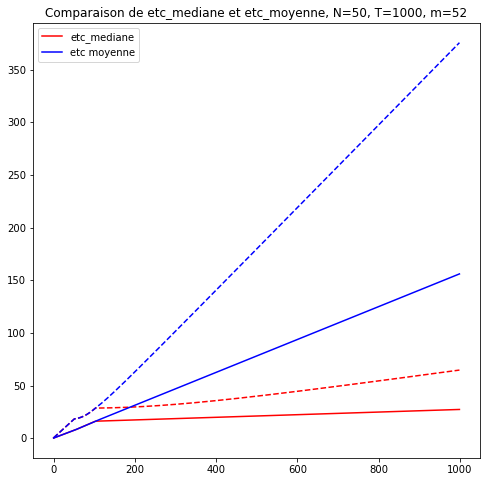

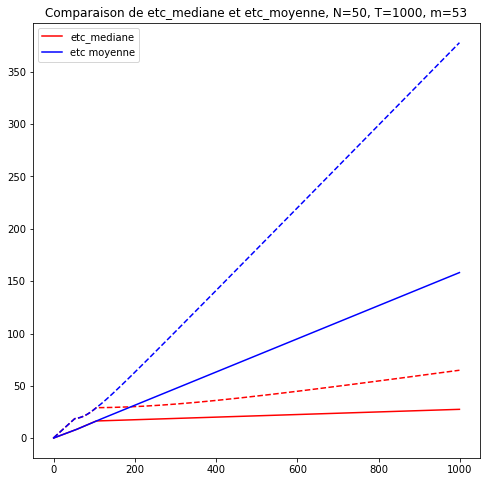

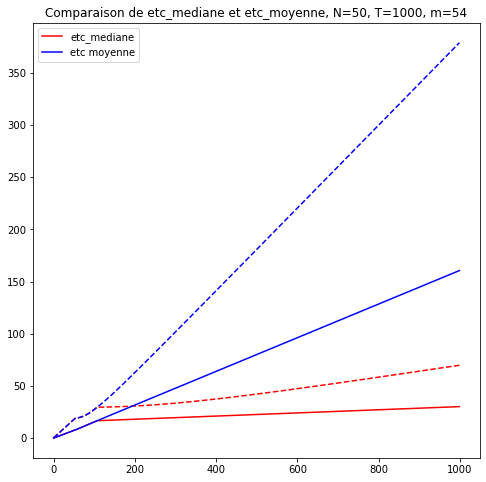

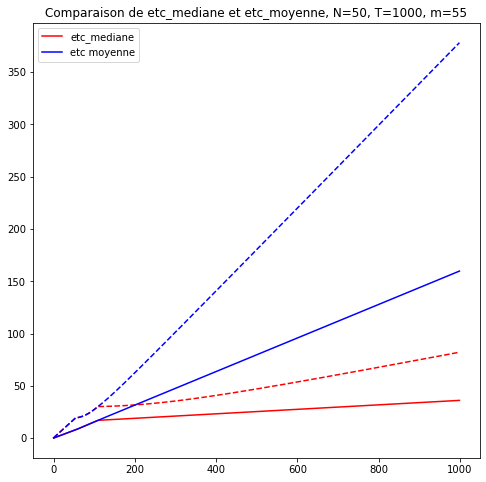

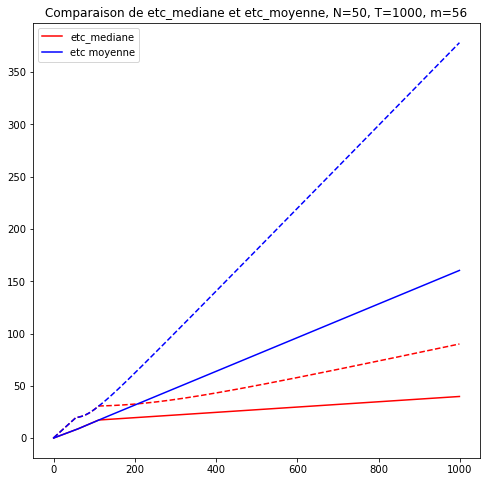

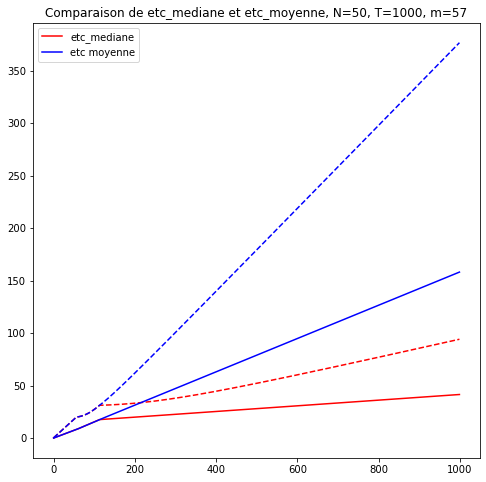

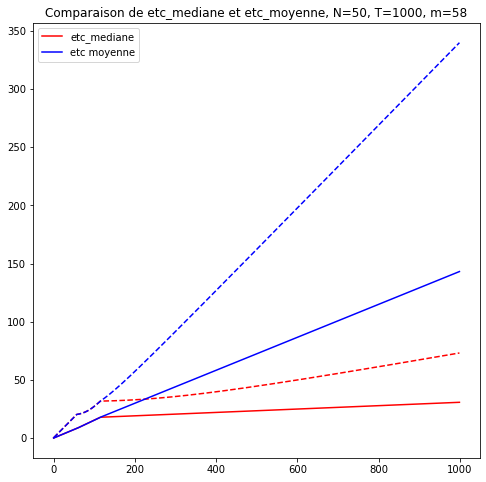

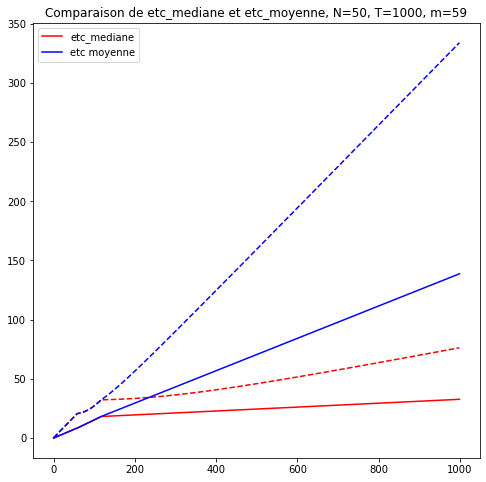

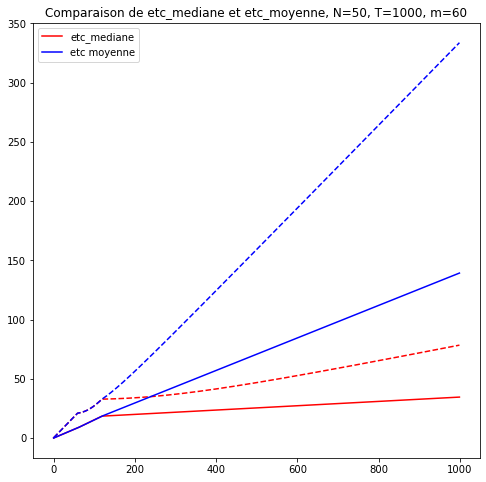

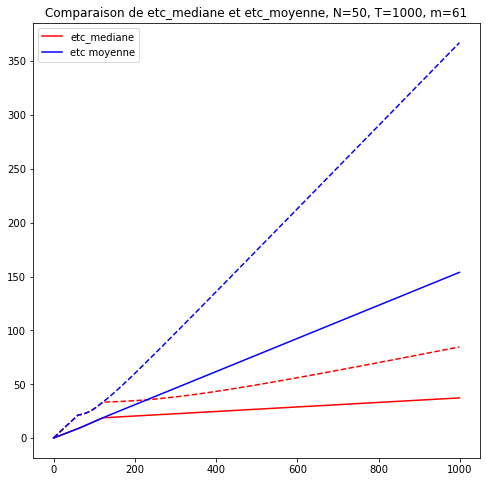

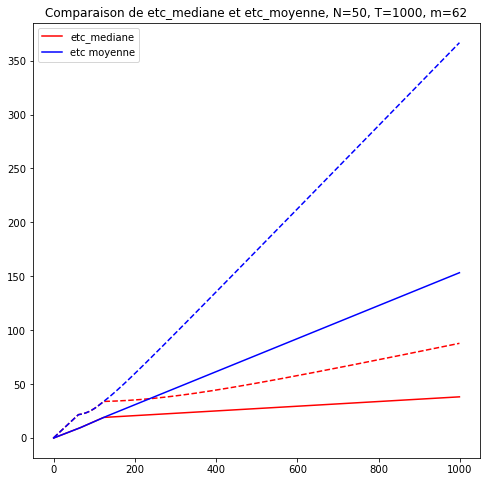

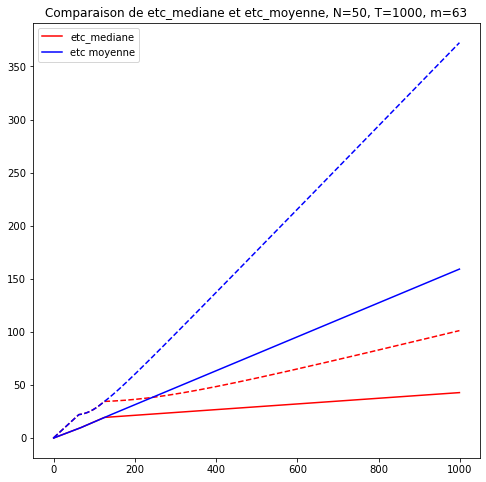

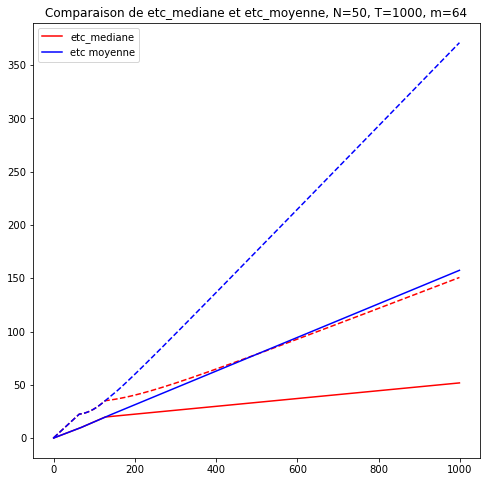

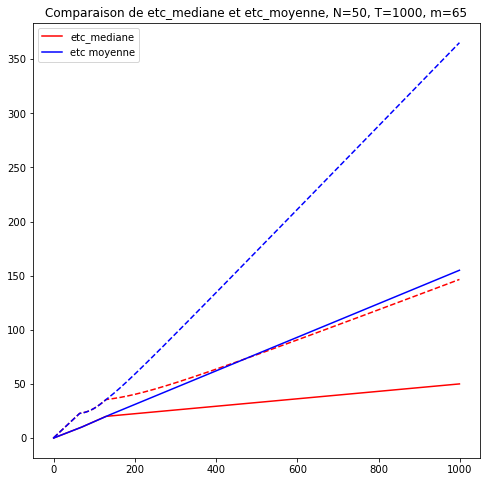

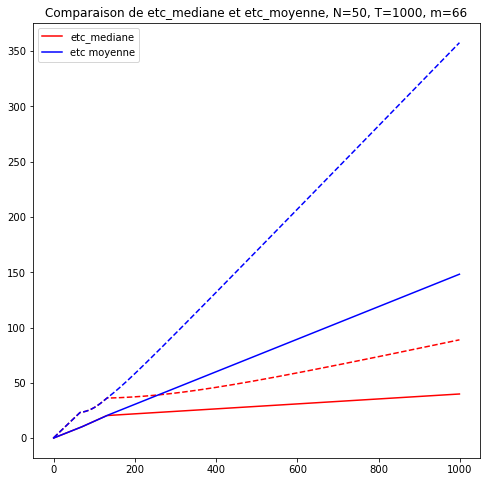

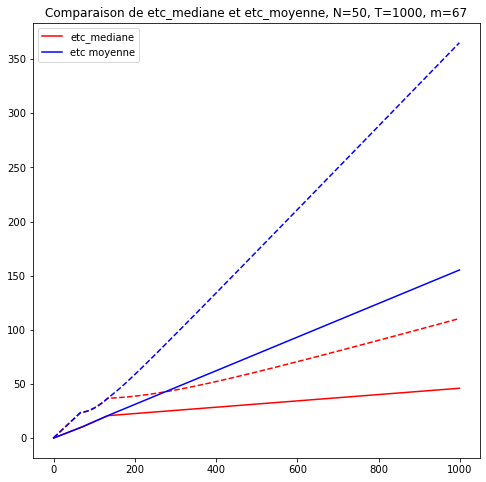

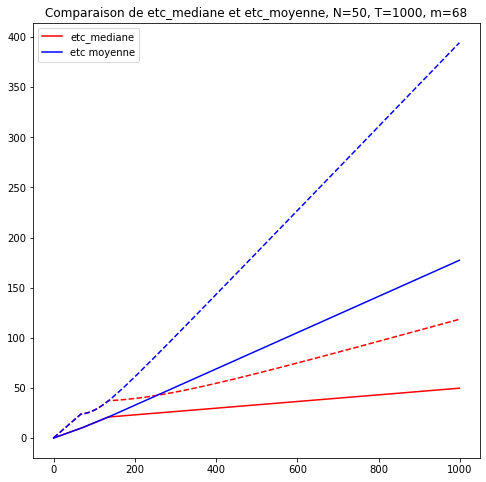

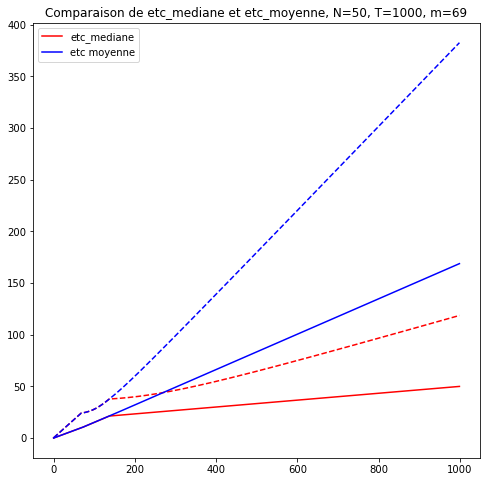

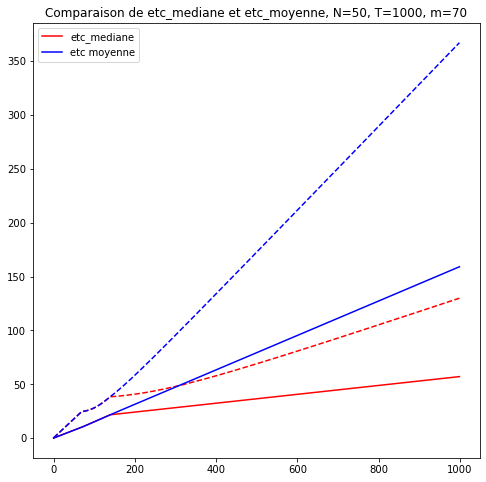

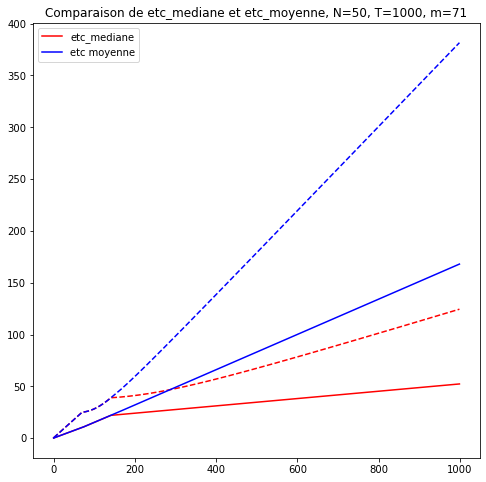

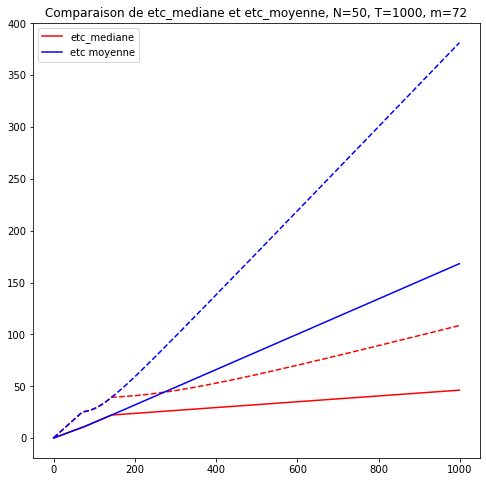

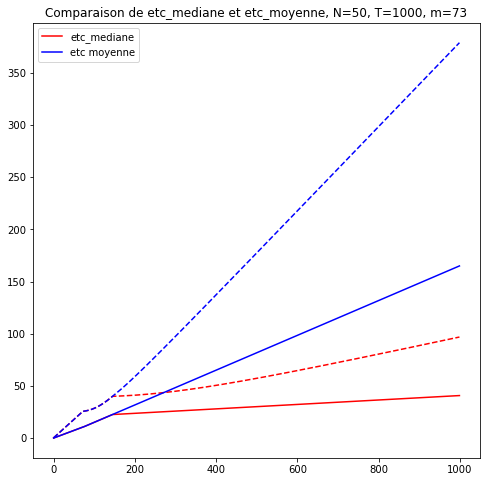

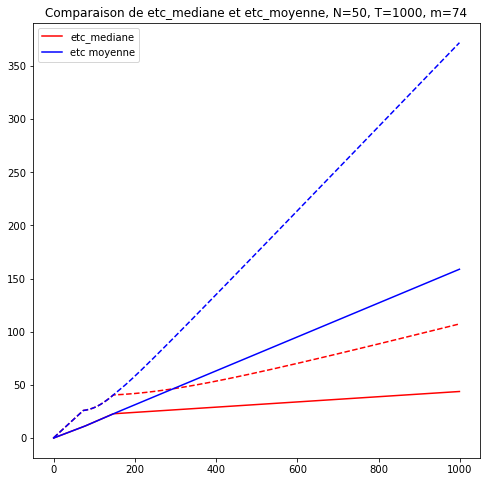

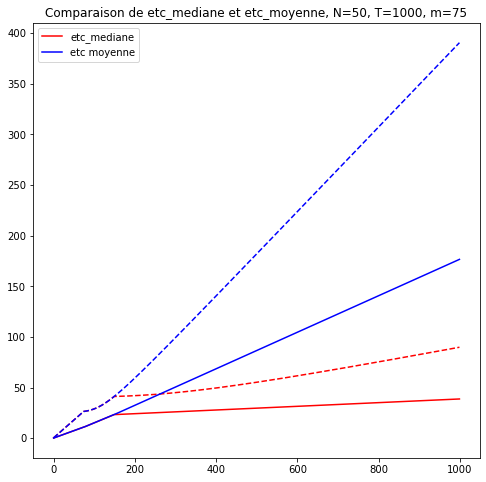

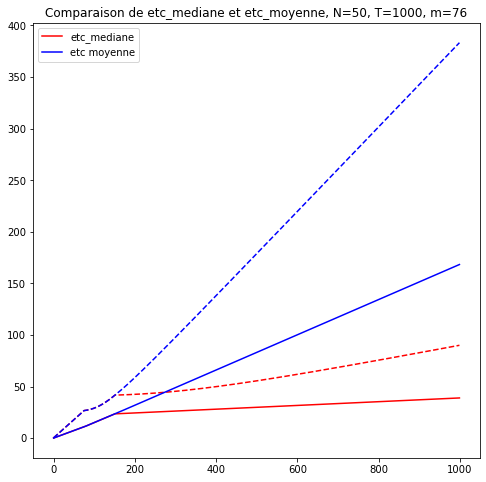

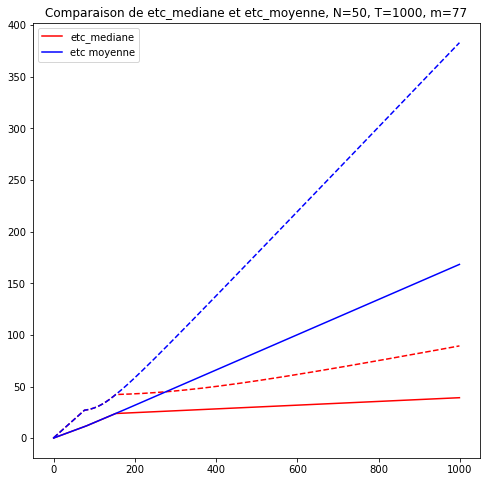

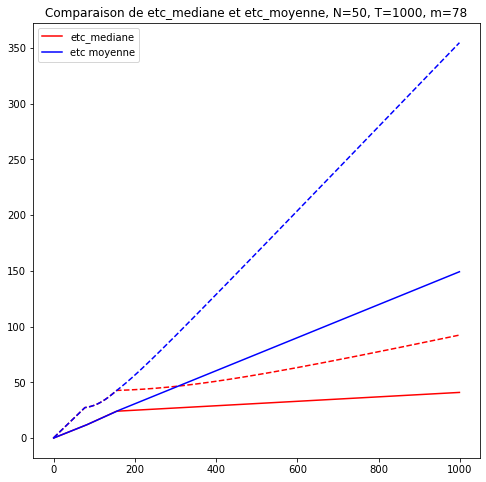

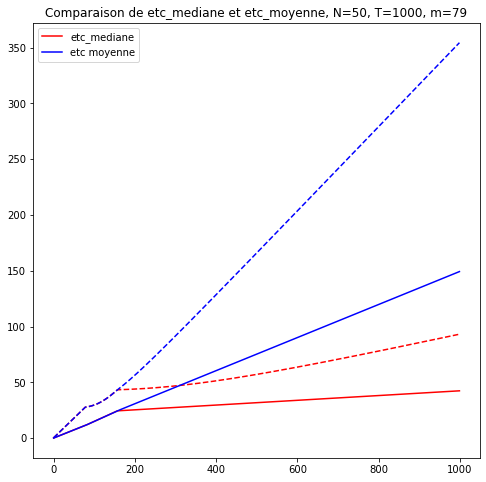

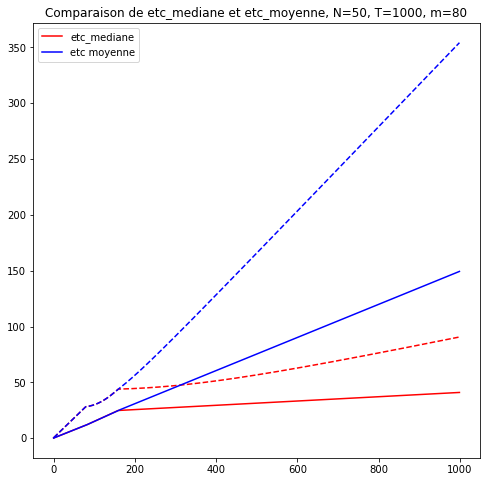

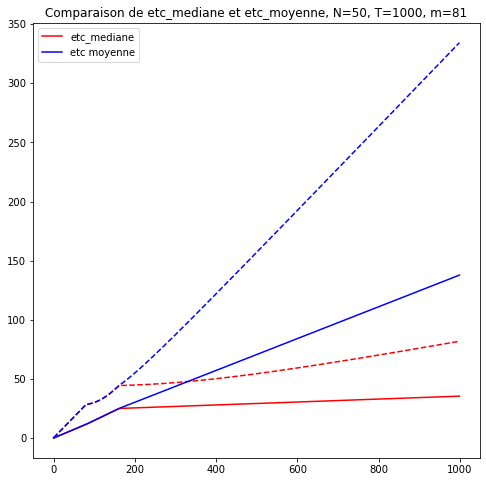

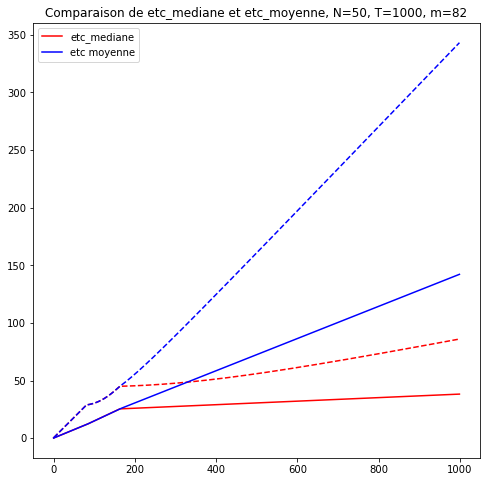

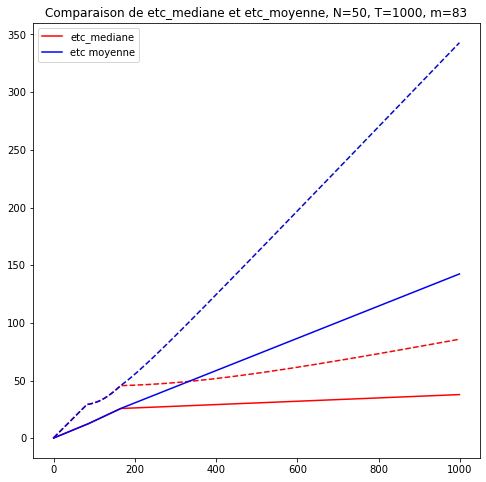

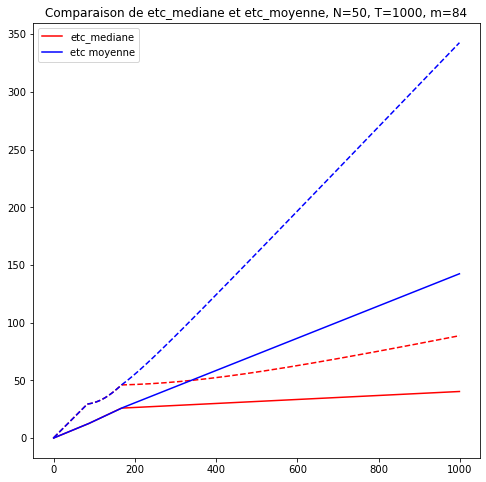

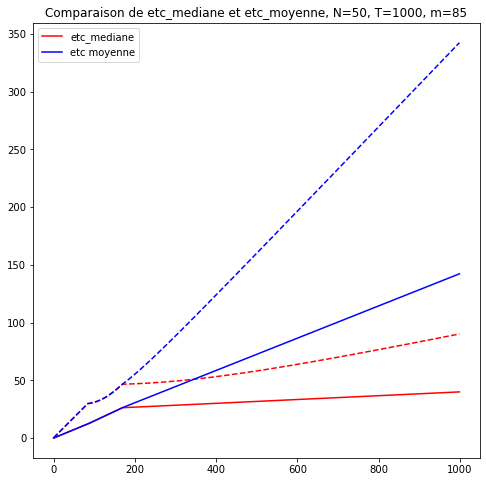

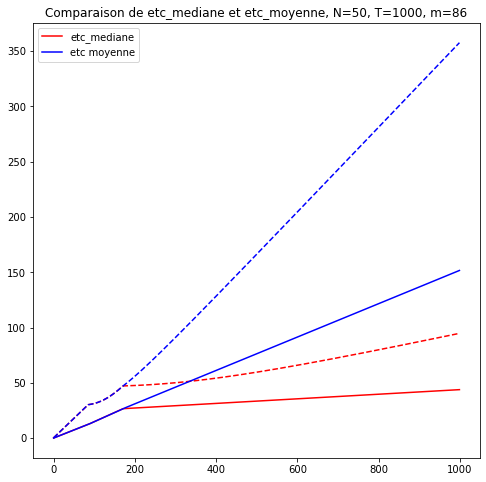

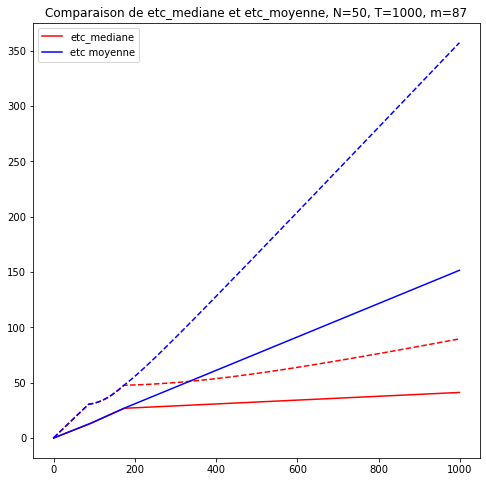

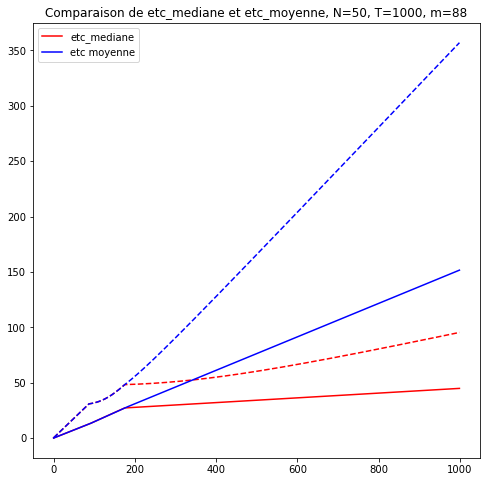

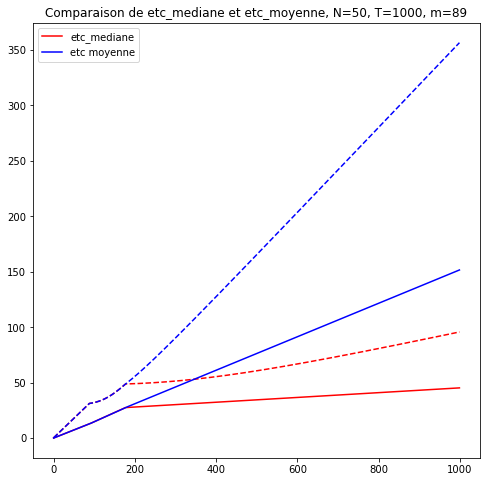

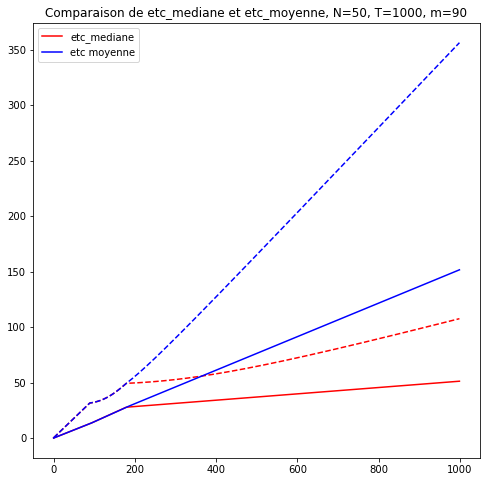

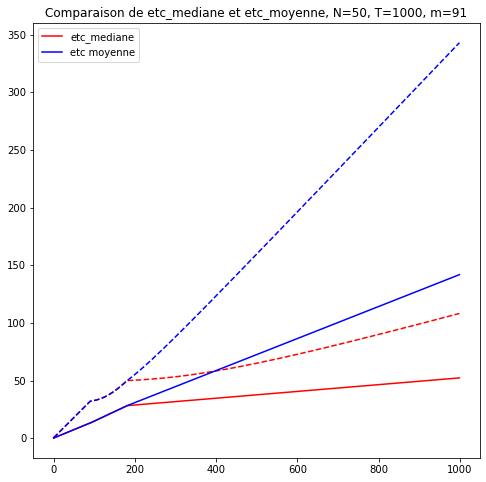

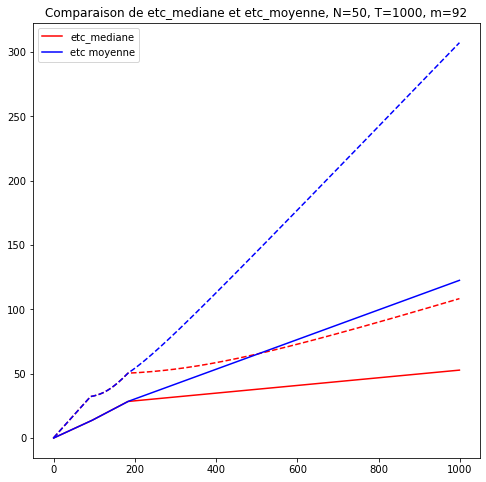

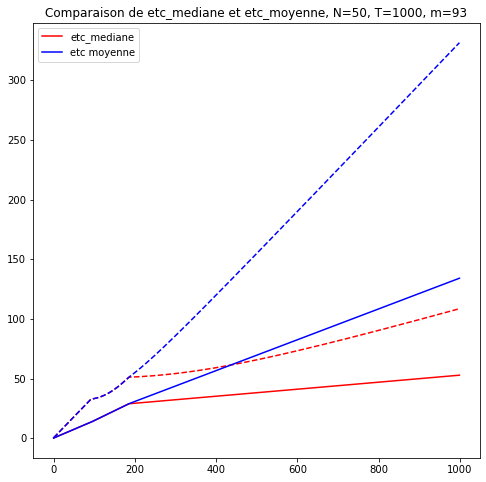

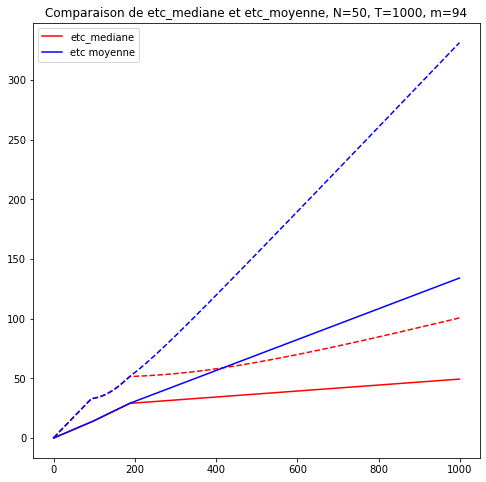

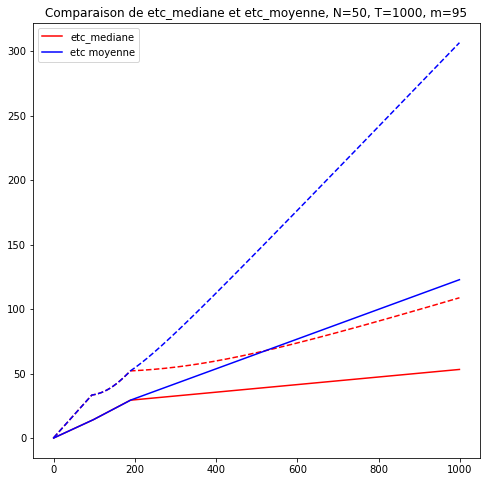

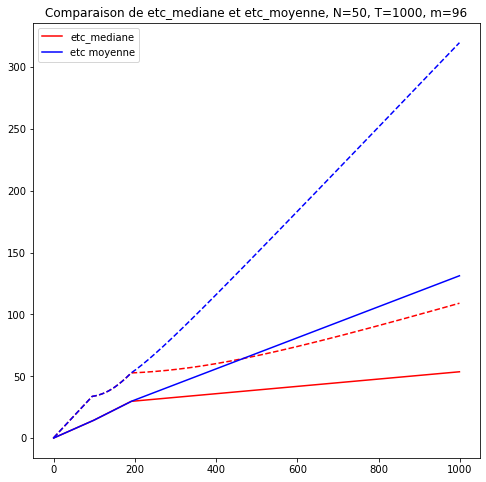

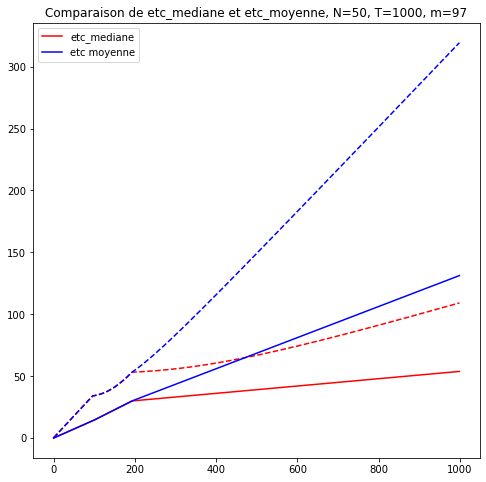

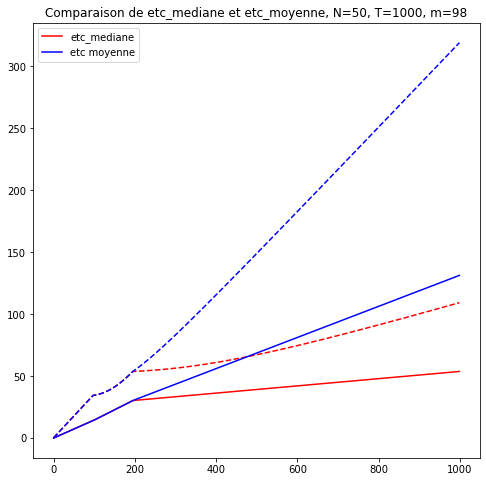

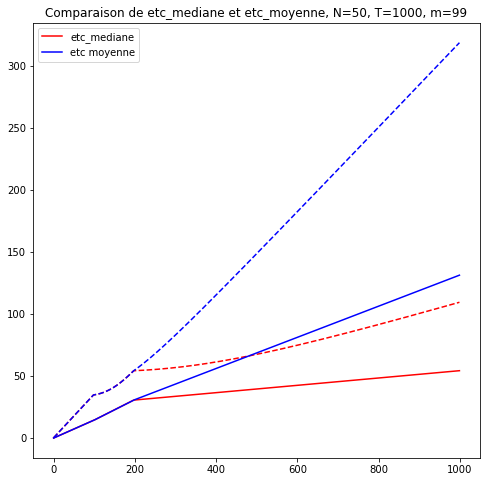

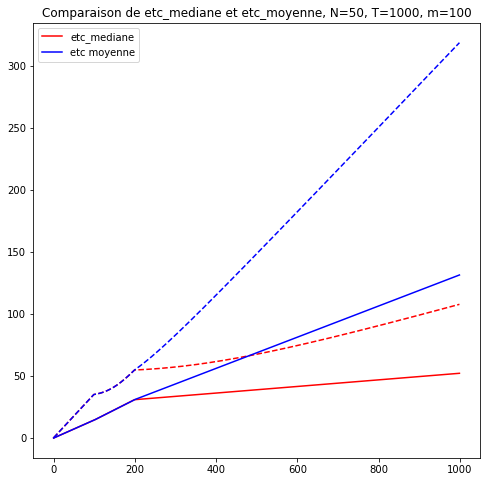

In [10]:
N,T = 50, 1000
loc=np.random.rand(50,2)
scale=np.array([1,1])

for m in range(1,101):

    cum_regrets_etc_median = []

    for i in range(N):
        banditest = CauchyBandit(loc=loc[i],scale=scale,seed=i)
        etc(banditest, T=T, m=m, discret=False, median=True)
        cum_regrets_etc_median.append(banditest.get_cumulative_regret())

    cum_regrets_etc_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_median)
    cum_regrets_etc_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_median)

    plt.plot(range(T),cum_regrets_etc_median_moy,color='red',label="etc_mediane") 
    plt.plot(range(T),cum_regrets_etc_median_moy + cum_regrets_etc_median_sd,color='red', linestyle='dashed')

    cum_regrets_etc_moyenne = []

    for i in range(N):
        banditest = CauchyBandit(loc=loc[i],scale=scale,seed=i)
        etc(banditest, T=T, m=m, discret=False, median=False)
        cum_regrets_etc_moyenne.append(banditest.get_cumulative_regret())
    
    cum_regrets_etc_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_moyenne)
    cum_regrets_etc_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_moyenne)

    plt.plot(range(T),cum_regrets_etc_moyenne_moy, color='blue',label='etc moyenne') 
    plt.plot(range(T),cum_regrets_etc_moyenne_moy + cum_regrets_etc_moyenne_sd, color='blue', linestyle='dashed')

    plt.title('Comparaison de etc_mediane et etc_moyenne, N={}, T={}, m={}'.format(N,T,m))
    plt.legend()
    plt.show()

#print(cum_regrets)
#print(cum_regrets_moy)
#print(cum_regrets_sd)

Ci-dessous, on définit epsilon_greedy avec l'option de median pour le calcul de l'estimateur.

In [11]:
def epsilon_greedy(bandit, epsilon, T, median=False):
    '''Play the given bandit over T rounds and return the greedy action . '''
    
    K = bandit.get_K()  #Obtention du nombre d'actions possibles.
    r = np.zeros(T)        #Préparation du vecteur de rewards, init. 0
    
    # Préparation d'une liste de K listes prêt à contenir les rewards pour chacune des K actions.
    R = []
    for i in range(K):
        R.append([])
    
    #Préparation d'un vecteur pour l'estimateur empirique de chaque action
    #initialisée à 0. L'estimateur empirique sera la moyenne ou la médiane
    
    estimateur = np.zeros(K) 
                                        
    #Le jeu commence
    for t in range(T):
        
        kstar_est = np.where(estimateur == max(estimateur))[0]
    
        #Traitement du bris d'égalité
        if (len(kstar_est) > 1): 
            kstar_est = np.random.choice(kstar_est,1)[0]
            
        if (np.random.rand(1) < epsilon):
            #explorer, jouer une des actions au hasard.
            action_played = np.random.choice(range(K),1)[0]
            r[t]=bandit.play(action_played)
            
        else:
            #exploiter, jouer l'action estimée optimale jusqu'à présent
            if(isinstance(kstar_est,np.ndarray)):
                kstar_est=kstar_est[0]
            
            action_played = kstar_est
            
            r[t] = bandit.play(action_played)
        
        #ajout du rewards dans l'historique de l'action jouée
        
        R[action_played].append(r[t])
    
        #Modifier la moyenne ou la médiane de l'action jouée
        if(median):
            estimateur[action_played]=np.median(R[action_played])
        else:
            estimateur[action_played]=np.mean(R[action_played])
            

Tests sur epsilon_greedy, comparaison des méthodes utilisées pour l'estimation

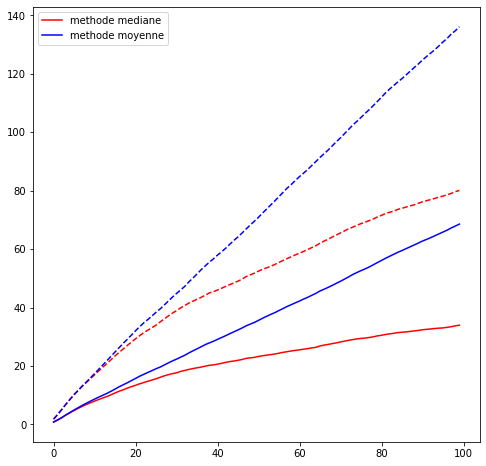

In [12]:
N,T = 50, 100

epsilon=0.1

loc=np.array([4,6])
scale=np.array([1,1])

cum_regrets_epsilon_greedy_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=i)
    epsilon_greedy(banditest, T=T, epsilon=epsilon, median=True)
    cum_regrets_epsilon_greedy_median.append(banditest.get_cumulative_regret())

cum_regrets_epsilon_greedy_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_median)
cum_regrets_epsilon_greedy_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_median)

plt.plot(range(T),cum_regrets_epsilon_greedy_median_moy,color='red',label='methode mediane') #affichage du graphique
plt.plot(range(T),cum_regrets_epsilon_greedy_median_moy + cum_regrets_epsilon_greedy_median_sd,color='red', linestyle='dashed')

cum_regrets_epsilon_greedy_moyenne = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=i)
    epsilon_greedy(banditest, T=T, epsilon=epsilon, median=False)
    cum_regrets_epsilon_greedy_moyenne.append(banditest.get_cumulative_regret())

cum_regrets_epsilon_greedy_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_moyenne)
cum_regrets_epsilon_greedy_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_moyenne)

plt.plot(range(T),cum_regrets_epsilon_greedy_moyenne_moy,color='blue',label='methode moyenne') #affichage du graphique
plt.plot(range(T),cum_regrets_epsilon_greedy_moyenne_moy + cum_regrets_epsilon_greedy_moyenne_sd,color='blue', linestyle='dashed')

plt.legend()

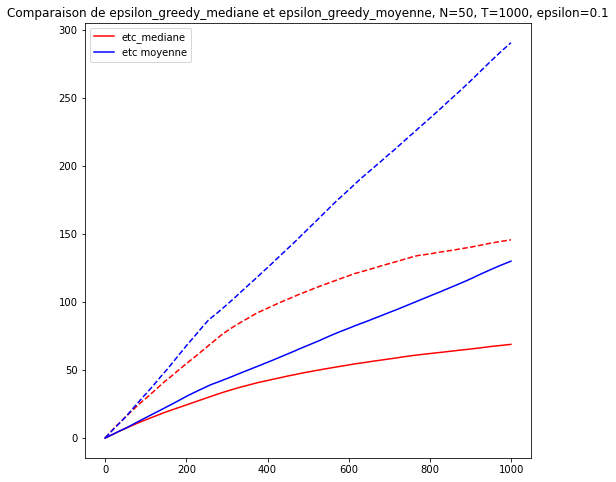

In [14]:
N,T = 50, 1000
epsilon=0.1

loc=np.random.rand(50,2)
scale=np.array([1,1])


cum_regrets_epsilon_greedy_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=i)
    epsilon_greedy(banditest, T=T, epsilon=epsilon, median=True)
    cum_regrets_epsilon_greedy_median.append(banditest.get_cumulative_regret())

cum_regrets_epsilon_greedy_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_median)
cum_regrets_epsilon_greedy_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_median)

plt.plot(range(T),cum_regrets_epsilon_greedy_median_moy,color='red',label="etc_mediane") 
plt.plot(range(T),cum_regrets_epsilon_greedy_median_moy + cum_regrets_epsilon_greedy_median_sd,color='red', linestyle='dashed')

cum_regrets_epsilon_greedy_moyenne = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=i)
    epsilon_greedy(banditest, T=T, epsilon=epsilon, median=False)
    cum_regrets_epsilon_greedy_moyenne.append(banditest.get_cumulative_regret())
    
cum_regrets_epsilon_greedy_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_moyenne)
cum_regrets_epsilon_greedy_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_moyenne)

plt.plot(range(T),cum_regrets_epsilon_greedy_moyenne_moy, color='blue',label='etc moyenne') 
plt.plot(range(T),cum_regrets_epsilon_greedy_moyenne_moy + cum_regrets_epsilon_greedy_moyenne_sd, color='blue', linestyle='dashed')

plt.title('Comparaison de epsilon_greedy_mediane et epsilon_greedy_moyenne, N={}, T={}, epsilon={}'.format(N,T,epsilon))
plt.legend()
plt.show()

#print(cum_regrets)
#print(cum_regrets_moy)
#print(cum_regrets_sd)

Ci-dessous, on définit epsilon_greedy_rule (règle $\epsilon=1/\sqrt{t}$) avec l'option de median pour le calcul de l'estimateur.


In [15]:
# Algorithme Greedy-epsilon avec epsilon=1/sqrt(t)

def epsilon_greedy_rule(bandit, T, median=False):
    '''Play the given bandit over T rounds and return the greedy action . '''
    
    K = bandit.get_K()  #Obtention du nombre d'actions possibles.
    r = np.zeros(T)        #Préparation du vecteur de rewards, init. 0
    
    # Préparation d'une liste de K listes prêt à contenir les rewards pour chacune des K actions.
    R = []
    for i in range(K):
        R.append([])
    
    
    #Préparation d'un vecteur pour l'estimateur empirique de chaque action
    #initialisée à 0. L'estimateur empirique sera la moyenne ou la médiane
    estimateur = np.zeros(K)
    
    #Le jeu commence
    for t in range(T):
    
        epsilon = min([1,1/sqrt(t+1)]) #Ici, c'est t+1 car t commence à 0 dans Python.
            
        kstar_est = np.where(estimateur == max(estimateur))[0]
    
        #Traitement du bris d'égalité
        if (len(kstar_est) > 1): 
            kstar_est = np.random.choice(kstar_est,1)[0]
            
        if (np.random.rand(1) < epsilon):
            #explorer, jouer une des actions au hasard.
            action_played = np.random.choice(range(K),1)[0]
            r[t]=bandit.play(action_played)
            
        else:
            #exploiter, jouer l'action estimée optimale jusqu'à présent
            if(isinstance(kstar_est,np.ndarray)):
                kstar_est=kstar_est[0]
            
            action_played = kstar_est
            
            r[t] = bandit.play(action_played)
        
        #ajout du rewards dans l'historique de l'action jouée
        
        R[action_played].append(r[t])
    
        #Modifier la moyenne ou la médiane de l'action jouée
        if median:
            estimateur[action_played]=np.median(R[action_played])
        else:
            estimateur[action_played]=np.mean(R[action_played])

Tests sur epsilon_greedy_rule , comparaison des méthodes utilisées pour l'estimation


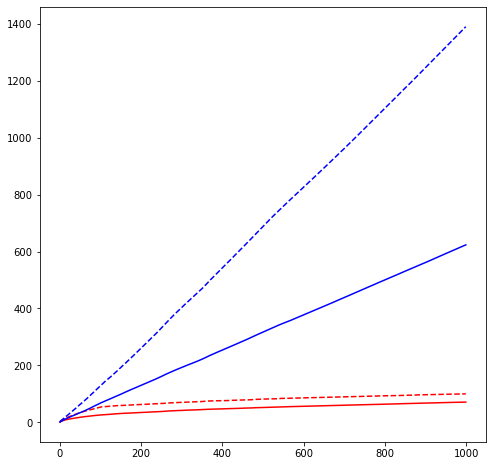

In [21]:
N,T = 50, 1000

loc=np.array([4,6])
scale=np.array([1,1])

cum_regrets_epsilon_greedy_rule_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=i)
    epsilon_greedy_rule(banditest, T=T, median=True)
    cum_regrets_epsilon_greedy_rule_median.append(banditest.get_cumulative_regret())

cum_regrets_epsilon_greedy_rule_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_rule_median)
cum_regrets_epsilon_greedy_rule_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_rule_median)

plt.plot(range(T),cum_regrets_epsilon_greedy_rule_median_moy,color='red') #affichage du graphique
plt.plot(range(T),cum_regrets_epsilon_greedy_rule_median_moy + cum_regrets_epsilon_greedy_rule_median_sd,color='red', linestyle='dashed')

cum_regrets_epsilon_greedy_rule_moyenne = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=i)
    epsilon_greedy_rule(banditest, T=T, median=False)
    cum_regrets_epsilon_greedy_rule_moyenne.append(banditest.get_cumulative_regret())
 
cum_regrets_epsilon_greedy_rule_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_rule_moyenne)
cum_regrets_epsilon_greedy_rule_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_rule_moyenne)

plt.plot(range(T),cum_regrets_epsilon_greedy_rule_moyenne_moy,color='blue') #affichage du graphique
plt.plot(range(T),cum_regrets_epsilon_greedy_rule_moyenne_moy + cum_regrets_epsilon_greedy_rule_moyenne_sd,color='blue', linestyle='dashed')



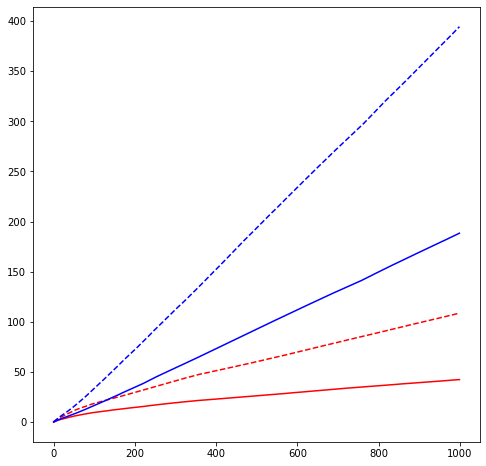

In [22]:
N,T = 50, 1000
epsilon=0.1

loc=np.random.rand(50,2)
scale=np.array([1,1])

cum_regrets_epsilon_greedy_rule_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=i)
    epsilon_greedy_rule(banditest, T=T, median=True)
    cum_regrets_epsilon_greedy_rule_median.append(banditest.get_cumulative_regret())

cum_regrets_epsilon_greedy_rule_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_rule_median)
cum_regrets_epsilon_greedy_rule_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_rule_median)

plt.plot(range(T),cum_regrets_epsilon_greedy_rule_median_moy,color='red') #affichage du graphique
plt.plot(range(T),cum_regrets_epsilon_greedy_rule_median_moy + cum_regrets_epsilon_greedy_rule_median_sd,color='red', linestyle='dashed')

cum_regrets_epsilon_greedy_rule_moyenne = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=i)
    epsilon_greedy_rule(banditest, T=T, median=False)
    cum_regrets_epsilon_greedy_rule_moyenne.append(banditest.get_cumulative_regret())
 
cum_regrets_epsilon_greedy_rule_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_rule_moyenne)
cum_regrets_epsilon_greedy_rule_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_rule_moyenne)

plt.plot(range(T),cum_regrets_epsilon_greedy_rule_moyenne_moy,color='blue') #affichage du graphique
plt.plot(range(T),cum_regrets_epsilon_greedy_rule_moyenne_moy + cum_regrets_epsilon_greedy_rule_moyenne_sd,color='blue', linestyle='dashed')


Explorations potentielles:

-Étendre les similuations ci-dessus à des estimateurs robustes autres que la médiane (comme la moyenne tronquée ou autre).
Au lieu, d'avoir un boléen pour déterminer la méthode de calcul de l'estimateur, ça pourrait être un string qui détermine la quelle méthode utilisée dans une liste de méthode.

-Étendre les simulations ci-dessus à des algorithmes plus complexes.

-Est-ce que cela nous démarque suffisemment de la littérature? Certains articles étudient l'utilisation des mesures statistiques plus robuste que la moyenne dans le cas de distribution avec premier moment fini (et deuxième) mais avec des distributions non-sigma-sousgaussienne.

-Tenter de définir le problème (mesure de performance) avec des distributions d'espérance non-définie et de formes non-symétriques, par exemple distribution de Pareto avec $k=1.$ 

-Tenter de trouver des applications.